/tmp/ipykernel_80909/3499025065.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_df['color'] = mapped_df['agreement_class'].map(agreement_color_map).fillna('black')


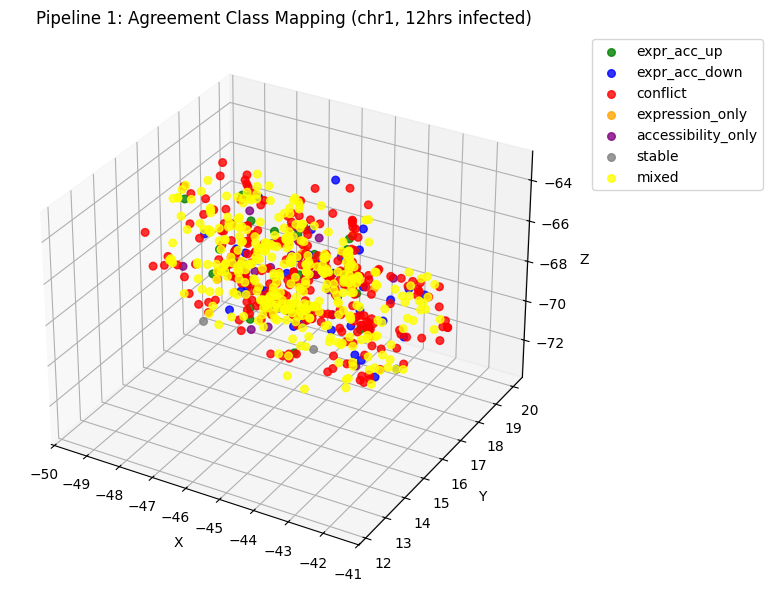

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
temporal_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/temporal_data/chr1_temporal_trendCategories_valuePattern_curveFeatures.csv")
structure_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv")

# Keep only needed columns from temporal data
temporal_subset = temporal_df[['gene_name', 'agreement_class']]

# Merge with structure coordinates for matching genes
merged_df = pd.merge(structure_df, temporal_subset, on='gene_name', how='inner')

# Prepare data for mapping
mapped_df = merged_df[['gene_name', 'middle_x', 'middle_y', 'middle_z', 'agreement_class']]

# Define color mapping for agreement classes
agreement_color_map = {
    'expr_acc_up': 'green',
    'expr_acc_down': 'blue',
    'conflict': 'red',
    'expression_only': 'orange',
    'accessibility_only': 'purple',
    'stable': 'gray',
    'mixed': 'yellow'
}

mapped_df['color'] = mapped_df['agreement_class'].map(agreement_color_map).fillna('black')

# Plot static 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cls, color in agreement_color_map.items():
    subset = mapped_df[mapped_df['agreement_class'] == cls]
    ax.scatter(subset['middle_x'], subset['middle_y'], subset['middle_z'],
               c=color, label=cls, s=30, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pipeline 1: Agreement Class Mapping (chr1, 12hrs infected)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
import trimesh
import numpy as np

# Load the mesh from OBJ
mesh = trimesh.load("data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj")

# Extract vertices
vertices = np.array(mesh.vertices)

# Gene coordinates and agreement class mapped_df
gene_coords = mapped_df[['middle_x', 'middle_y', 'middle_z']].values
gene_classes = mapped_df['agreement_class'].values

# Map agreement classes to colors (RGB)
color_map_rgb = {
    'expr_acc_up': (0, 255, 0),       # green
    'expr_acc_down': (0, 0, 255),     # blue
    'conflict': (255, 0, 0),          # red
    'expression_only': (255, 165, 0), # orange
    'accessibility_only': (128, 0, 128), # purple
    'stable': (128, 128, 128),        # gray
    'mixed': (255, 255, 0),           # yellow
}

# Assign nearest gene to each mesh vertex
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(gene_coords)
distances, indices = nn.kneighbors(vertices)

# Map vertices to gene agreement class
vertex_classes = gene_classes[indices[:, 0]]

# Convert classes to RGB colors
vertex_colors = np.array([color_map_rgb.get(cls, (0, 0, 0)) for cls in vertex_classes], dtype=np.uint8)

# Add vertex colors to the mesh
mesh.visual.vertex_colors = vertex_colors

# Export the colored mesh to a new OBJ for viewing
output_path = "data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj"
mesh.export(output_path)

output_path


'data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj'

In [7]:
import trimesh

# Load the colored mesh
mesh = trimesh.load("data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj")
print(mesh.vertices.shape, mesh.faces.shape)
print(mesh.is_watertight, mesh.is_winding_consistent)

# Create a scene
scene = trimesh.Scene(mesh)

# Show in JupyterLab (interactive WebGL)
scene.show()


(15262, 3) (30536, 3)
True True


In [8]:
# Show basic info
merged_preview = merged_df[['gene_name', 'middle_x', 'middle_y', 'middle_z', 'agreement_class']].head()
merged_count = len(merged_df)

merged_preview, merged_count

(  gene_name   middle_x   middle_y   middle_z     agreement_class
 0     BET1L -43.838707  14.244620 -66.835629            conflict
 1     RIC8A -43.880255  14.211091 -66.794623               mixed
 2     SIRT3 -44.024084  14.095021 -66.652669               mixed
 3    PSMD13 -44.130924  14.008801 -66.547223            conflict
 4     NLRP6 -44.325496  13.851781 -66.355188  accessibility_only,
 802)

In [6]:
import os
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from skimage.measure import marching_cubes
import trimesh
from sklearn.neighbors import NearestNeighbors

# ---- Load merged data (structure + agreement) ----
df = merged_df.copy()

# ---- Utility: Estimate radius using nearest neighbor distance ----
def estimate_radius_nnd(points, scale=1.5):
    nbrs = NearestNeighbors(n_neighbors=2).fit(points)
    distances, _ = nbrs.kneighbors(points)
    avg_dist = np.mean(distances[:, 1])
    return avg_dist * scale

# ---- Create scalar field via metaball union ----
def create_metaball_field(points, grid_resolution=100, radius=5.0, grid_margin=10):
    mins = points.min(axis=0) - grid_margin
    maxs = points.max(axis=0) + grid_margin
    dims = (maxs - mins)
    spacing = dims / grid_resolution

    x = np.linspace(mins[0], maxs[0], grid_resolution)
    y = np.linspace(mins[1], maxs[1], grid_resolution)
    z = np.linspace(mins[2], maxs[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    field = np.zeros_like(X)

    for p in points:
        d2 = (X - p[0])**2 + (Y - p[1])**2 + (Z - p[2])**2
        field += np.exp(-d2 / (2 * radius**2))

    return field, (x, y, z)

# ---- Automatically detect marching cube level ----
def auto_select_level(field, grid_axes, level_range=(0.3, 0.7), steps=10):
    best_level = None
    best_score = -np.inf
    levels = np.linspace(level_range[0], level_range[1], steps)

    for lvl in levels:
        try:
            verts, faces, _, _ = marching_cubes(field, level=lvl)
            surface_area = trimesh.Trimesh(vertices=verts, faces=faces).area
            score = -abs(surface_area - 10000)  # target surface area
            if score > best_score:
                best_score = score
                best_level = lvl
        except Exception:
            continue

    return best_level

# ---- Extract surface from scalar field ----
def extract_metaball_surface(field, grid_axes, level=0.5):
    verts, faces, _, _ = marching_cubes(field, level=level)
    x, y, z = grid_axes
    spacing = [(a[1] - a[0]) for a in grid_axes]
    origin = [a[0] for a in grid_axes]
    verts_world = verts * spacing + origin
    return trimesh.Trimesh(vertices=verts_world, faces=faces, process=False)

# ---- Run Localized Metaball Pipeline ----
def run_local_metaball_pipeline_per_class(merged_df, out_dir, resolution=100):
    os.makedirs(out_dir, exist_ok=True)
    exported = []

    for cls in merged_df['agreement_class'].unique():
        points = merged_df[merged_df['agreement_class'] == cls][['middle_x', 'middle_y', 'middle_z']].dropna().values
        if len(points) < 4:
            continue

        print(f"Processing '{cls}' with {len(points)} points...")

        radius = estimate_radius_nnd(points, scale=1.5)
        field, axes = create_metaball_field(points, grid_resolution=resolution, radius=radius)
        level = auto_select_level(field, axes)
        print(f" → Radius: {radius:.2f}, Level: {level}")

        mesh = extract_metaball_surface(field, axes, level=level)

        out_path = os.path.join(out_dir, f"{cls.replace(' ', '_')}_local.obj")
        mesh.export(out_path)
        exported.append(out_path)

        print(f" → Saved: {out_path}")

    return exported

# ---- Example usage ----
# merged_df should already contain ['middle_x', 'middle_y', 'middle_z', 'agreement_class']
output_dir = "data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local"
exported_files = run_local_metaball_pipeline_per_class(df, output_dir, resolution=100)


Processing 'conflict' with 309 points...
 → Radius: 0.55, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/conflict_local.obj
Processing 'mixed' with 367 points...
 → Radius: 0.53, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/mixed_local.obj
Processing 'accessibility_only' with 25 points...
 → Radius: 1.61, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/accessibility_only_local.obj
Processing 'expr_acc_down' with 58 points...
 → Radius: 1.14, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/expr_acc_down_local.obj
Processing 'expr_acc_up' with 33 points...
 → Radius: 1.50, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/expr_acc_up_local.obj
Processing 'expression_only' with 8 points...
 → Radi

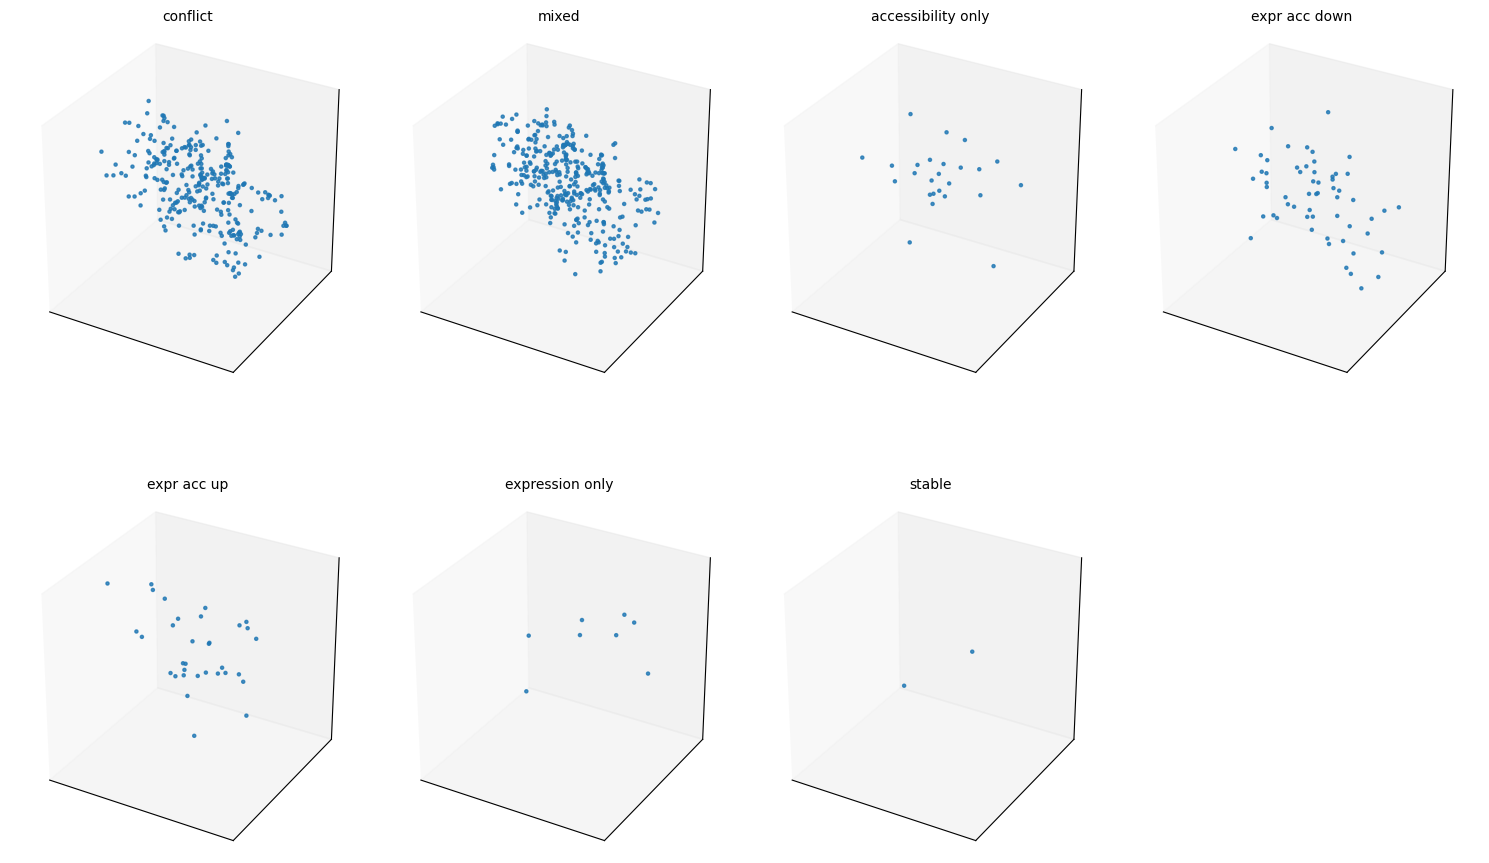

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# Columns
x_col = "middle_x"
y_col = "middle_y"
z_col = "middle_z"
group_col = "agreement_class"

# Unique agreement categories
agreement_classes = merged_df[group_col].dropna().unique()

# Create subplot grid
fig = plt.figure(figsize=(15, 10))
rows = 2
cols = int((len(agreement_classes) + 1) / 2)

for idx, cls in enumerate(agreement_classes):
    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    subset = merged_df[merged_df[group_col] == cls]

    ax.scatter(subset[x_col], subset[y_col], subset[z_col], s=5, alpha=0.8)
    ax.set_title(cls.replace("_", " "), fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()


In [11]:
import trimesh
import pyrender
import os

# Path to folder containing the OBJ files
base_path = "data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local"  # <-- update this

# Agreement categories
agreement_classes = [
    "conflict",
    "expression_only",
    "accessibility_only",
    "expr_acc_up",
    "expr_acc_down",
    "mixed"
]

# Color map
class_colors = {
    "conflict": [1.0, 0.2, 0.2],
    "expression_only": [0.2, 0.9, 0.2],
    "accessibility_only": [0.6, 0.2, 1.0],
    "expr_acc_up": [1.0, 0.5, 0.1],
    "expr_acc_down": [0.2, 0.9, 0.9],
    "mixed": [0.2, 0.5, 1.0]
}

# Create a scene
scene = pyrender.Scene(bg_color=[0, 0, 0, 1])

for i, cls in enumerate(agreement_classes):
    file_path = os.path.join(base_path, f"{cls}_local.obj")
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    mesh = trimesh.load(file_path, force="mesh")
    color = class_colors.get(cls, [0.5, 0.5, 0.5])

    # Apply uniform color to all vertices
    mesh.visual.vertex_colors = [int(c * 255) for c in color]

    # Convert to pyrender mesh
    render_mesh = pyrender.Mesh.from_trimesh(mesh)

    # Position in a grid
    x = (i % 3) * 60 - 60  # e.g., -60, 0, 60
    y = -(i // 3) * 60     # e.g., 0, -60
    node = pyrender.Node(mesh=render_mesh, translation=[x, y, 0])
    scene.add_node(node)

# Launch viewer
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, run_in_thread=False)


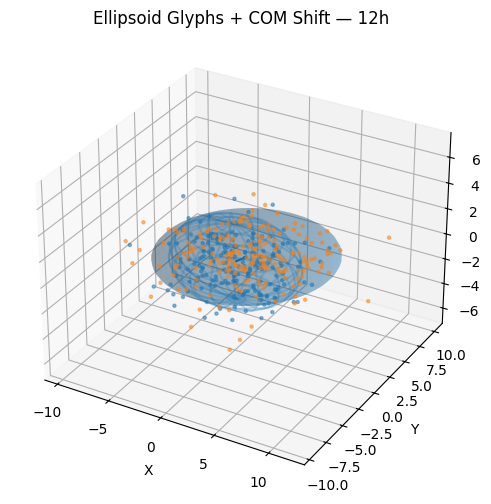

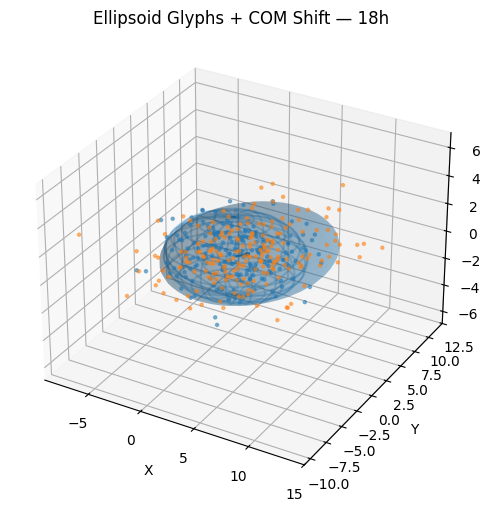

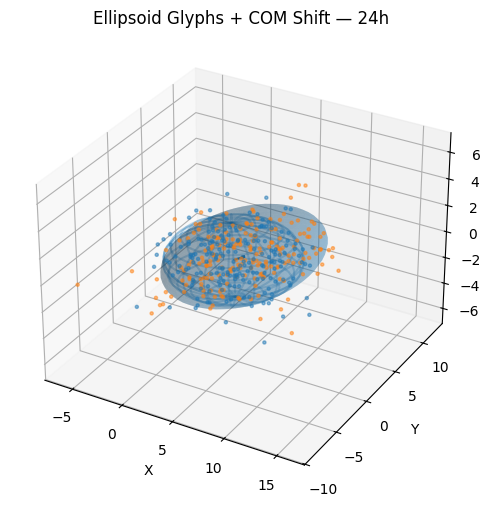

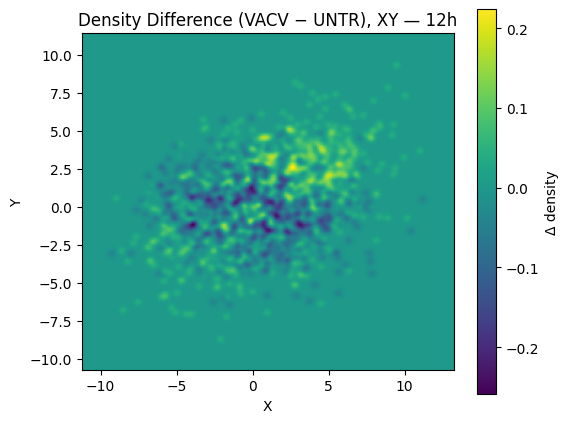

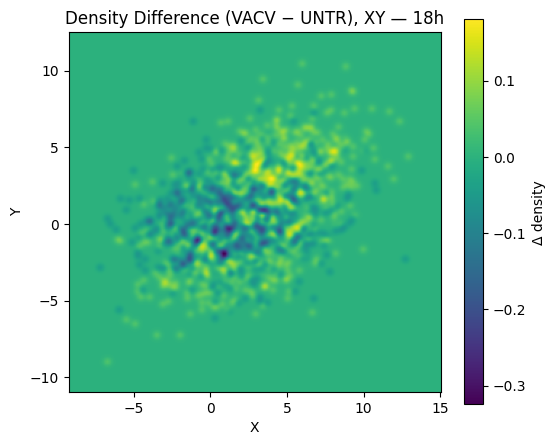

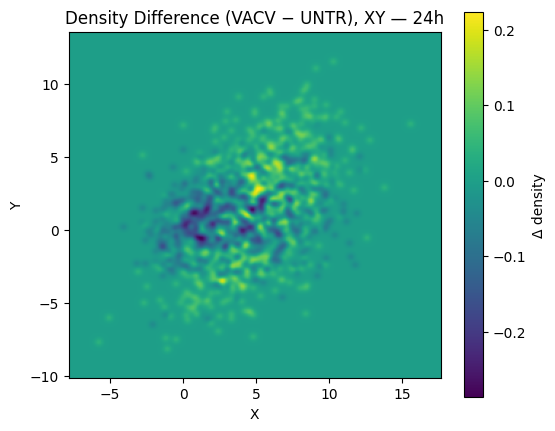

Done. Nothing saved; just displays.


In [2]:
# === TEST: Ellipsoid Glyphs + COM Arrow + 2D Difference Map (MOCK DATA ONLY) ===
# - No files saved, no external data. Good for ~1,000 pts/cond/timepoint.
# - Shows: per-timepoint UNTR vs VACV ellipsoids + COM shift, and a VACV-UNTR XY density diff map.

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple

np.random.seed(7)

# ----------------------------- Controls -----------------------------
TIMEPOINTS = ["12h", "18h", "24h"]
N_POINTS = 1000          # ~genes per condition per timepoint
ELLIPSOID_SCALE = 2.0    # visual inflation of PCA radii
DENSITY_RES = 256        # 2D diff map grid resolution
DENSITY_SIGMA = 2.0      # blur for smoother density maps
SCATTER_STRIDE = max(1, N_POINTS // 200)  # sample ~200 pts for faster scatter

# ----------------------------- Helpers -----------------------------
@dataclass
class EllipsoidGlyph:
    center: np.ndarray
    axes: np.ndarray
    R: np.ndarray
    volume: float

def fit_ellipsoid_pca(points: np.ndarray, scale: float = ELLIPSOID_SCALE) -> EllipsoidGlyph:
    center = points.mean(axis=0)
    X = points - center
    C = np.cov(X.T)
    vals, vecs = np.linalg.eigh(C)
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]; vecs = vecs[:, idx]
    radii = scale * np.sqrt(np.maximum(vals, 1e-12))
    volume = 4/3 * np.pi * np.prod(radii)
    return EllipsoidGlyph(center, radii, vecs, volume)

def plot_ellipsoid(ax, glyph: EllipsoidGlyph, alpha=0.25, wire=False):
    u = np.linspace(0, 2*np.pi, 36)
    v = np.linspace(0, np.pi, 24)
    x = glyph.axes[0] * np.outer(np.cos(u), np.sin(v))
    y = glyph.axes[1] * np.outer(np.sin(u), np.sin(v))
    z = glyph.axes[2] * np.outer(np.ones_like(u), np.cos(v))
    E = np.stack([x, y, z], axis=-1).reshape(-1, 3) @ glyph.R.T
    E = E.reshape(x.shape + (3,))
    X = E[...,0] + glyph.center[0]
    Y = E[...,1] + glyph.center[1]
    Z = E[...,2] + glyph.center[2]
    if wire:
        ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, alpha=alpha)
    else:
        ax.plot_surface(X, Y, Z, alpha=alpha)

def com_arrow(ax, c0, c1):
    d = c1 - c0
    ax.quiver(c0[0], c0[1], c0[2], d[0], d[1], d[2], length=1.0, normalize=False)

def make_density(img_size: int, pts: np.ndarray, bounds: Tuple[np.ndarray, np.ndarray], sigma_px: float = DENSITY_SIGMA):
    lo, hi = bounds
    xy = pts[:, :2]
    xy_norm = (xy - lo[:2]) / (hi[:2] - lo[:2] + 1e-9)
    px = np.clip((xy_norm * (img_size - 1)).astype(int), 0, img_size - 1)
    img = np.zeros((img_size, img_size), dtype=float)
    for i, j in px:
        img[j, i] += 1.0
    r = int(3*sigma_px)
    x = np.arange(-r, r+1)
    k = np.exp(-(x**2)/(2*sigma_px**2)); k /= k.sum()
    tmp = np.zeros_like(img)
    for y in range(img_size):
        row = img[y]
        padded = np.pad(row, (r, r), mode='edge')
        for x0 in range(img_size):
            tmp[y, x0] = np.dot(k, padded[x0:x0+2*r+1])
    out = np.zeros_like(img)
    for x0 in range(img_size):
        col = tmp[:, x0]
        padded = np.pad(col, (r, r), mode='edge')
        for y0 in range(img_size):
            out[y0, x0] = np.dot(k, padded[y0:y0+2*r+1])
    return out

def synth_cloud(center, scales, n=N_POINTS, rot_angle=0.0):
    cov = np.diag(np.array(scales)**2)
    pts = np.random.multivariate_normal(mean=[0,0,0], cov=cov, size=n)
    Rz = np.array([[np.cos(rot_angle), -np.sin(rot_angle), 0],
                   [np.sin(rot_angle),  np.cos(rot_angle), 0],
                   [0, 0, 1]])
    return pts @ Rz.T + np.array(center)

# ----------------------------- Mock data -----------------------------
data: Dict[str, Dict[str, np.ndarray]] = {}
for t_idx, tp in enumerate(TIMEPOINTS):
    shift = np.array([t_idx*2.0, 0.5*t_idx, 0.0])               # slow global drift over time
    untr = synth_cloud(shift + np.array([0,0,0]), [3.0, 2.0, 1.5], rot_angle=0.2*t_idx)
    vacv = synth_cloud(shift + np.array([1.0, 0.6, 0.2]), [3.8, 2.2, 1.6], rot_angle=0.5 + 0.25*t_idx)
    data[tp] = {"UNTR": untr, "VACV": vacv}

# ----------------------------- Show: 3D glyphs per timepoint -----------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
for tp in TIMEPOINTS:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Ellipsoid Glyphs + COM Shift — {tp}")

    g_untr = fit_ellipsoid_pca(data[tp]["UNTR"])
    g_vacv = fit_ellipsoid_pca(data[tp]["VACV"])

    plot_ellipsoid(ax, g_untr, alpha=0.25, wire=True)
    plot_ellipsoid(ax, g_vacv, alpha=0.25, wire=False)
    com_arrow(ax, g_untr.center, g_vacv.center)

    # sample scatter for speed
    ax.scatter(data[tp]["UNTR"][::SCATTER_STRIDE,0], data[tp]["UNTR"][::SCATTER_STRIDE,1], data[tp]["UNTR"][::SCATTER_STRIDE,2], s=5, alpha=0.5)
    ax.scatter(data[tp]["VACV"][::SCATTER_STRIDE,0], data[tp]["VACV"][::SCATTER_STRIDE,1], data[tp]["VACV"][::SCATTER_STRIDE,2], s=5, alpha=0.5)

    all_pts = np.vstack([data[tp]["UNTR"], data[tp]["VACV"]])
    lo = all_pts.min(axis=0) - 2
    hi = all_pts.max(axis=0) + 2
    ax.set_xlim(lo[0], hi[0]); ax.set_ylim(lo[1], hi[1]); ax.set_zlim(lo[2], hi[2])
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

# ----------------------------- Show: 2D XY density difference per timepoint -----------------------------
for tp in TIMEPOINTS:
    pts_untr = data[tp]["UNTR"]; pts_vacv = data[tp]["VACV"]
    all_pts = np.vstack([pts_untr, pts_vacv])
    lo = all_pts.min(axis=0) - 2
    hi = all_pts.max(axis=0) + 2
    D_untr = make_density(DENSITY_RES, pts_untr, (lo, hi))
    D_vacv = make_density(DENSITY_RES, pts_vacv, (lo, hi))
    diff = D_vacv - D_untr

    plt.figure(figsize=(6,5))
    plt.title(f"Density Difference (VACV − UNTR), XY — {tp}")
    plt.imshow(diff, origin="lower", extent=[lo[0], hi[0], lo[1], hi[1]])
    plt.colorbar(label="Δ density")
    plt.xlabel("X"); plt.ylabel("Y")
    plt.show()

print("Done. Nothing saved; just displays.")
